# AirBnB Listings in Los Angeles, CA
##### Data source: http://insideairbnb.com/get-the-data.html
##### Date compiled: May 8, 2020
## 3 - Modeling

### Dependencies

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import xgboost as xgb

from utils import utils, plotting

%matplotlib inline

In [2]:
# Settings
pd.options.display.max_columns = 200
pd.options.display.max_rows = 50000
sns.set()

### Data

In [3]:
listings = pd.read_pickle('data/listings2.pkl')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37028 entries, 0 to 37047
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                37028 non-null  int64         
 1   by_superhost                      37028 non-null  int64         
 2   neighborhood                      37028 non-null  object        
 3   zipcode                           37028 non-null  object        
 4   latitude                          37028 non-null  float64       
 5   longitude                         37028 non-null  float64       
 6   property_type                     37028 non-null  object        
 7   room_type                         37028 non-null  object        
 8   accommodates                      37028 non-null  int64         
 9   bathrooms                         37028 non-null  float64       
 10  bedrooms                          37028 non-nu

### Filter out listings with an outlier price

In [4]:
list765 = listings[listings.price <= 765].copy()
list765.head()

,id,by_superhost,neighborhood,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,score_rtg,score_accu,score_clean,score_check,score_comm,score_loc,score_val,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,109,0,Culver City,90230,33.98209,-118.38494,Condominium,Entire home/apt,6,2.0,2.0,3.0,122.0,500.0,240.0,3,25.0,30,0,0,0,38,2,0,2011-08-15,2016-05-15,80.0,10.0,10.0,6.0,8.0,10.0,8.0,0,strict_14_with_grace_period,1,0,0.02
1,344,0,Burbank,91505,34.16562,-118.33458,House,Entire home/apt,6,1.0,3.0,3.0,168.0,0.0,100.0,6,0.0,15,0,1,6,97,8,2,2016-06-14,2019-10-19,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,flexible,0,0,0.17
2,2708,1,Hollywood,90046,34.09768,-118.34602,Apartment,Private room,1,1.5,1.0,1.0,79.0,450.0,84.0,1,0.0,30,7,7,7,281,24,6,2014-06-09,2020-03-17,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,strict_14_with_grace_period,0,0,0.33
3,2732,0,Santa Monica,90405,34.00475,-118.48127,Apartment,Private room,1,1.0,1.0,1.0,155.0,0.0,100.0,1,0.0,1,30,60,90,365,21,3,2011-06-06,2019-12-27,94.0,9.0,9.0,9.0,9.0,10.0,9.0,0,strict_14_with_grace_period,0,0,0.19
4,2864,0,Bellflower,90706,33.87619,-118.11397,Apartment,Entire home/apt,2,1.0,1.0,1.0,80.0,100.0,75.0,2,25.0,15,0,0,0,0,0,0,2020-05-08,2020-05-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,strict_14_with_grace_period,0,0,0.00


### Feature elimination

In [5]:
# Remove unnecessary or redundant features
unnecessary_feats = ['id', 'zipcode', 'latitude', 'longitude', 'number_of_reviews', 'number_of_reviews_ltm', 'first_review', 'last_review']
list765.drop(unnecessary_feats, axis=1, inplace=True)
list765.shape

(35563, 30)

In [6]:
# Check for duplicate features
dup_feats = utils.dup_feats(df=list765)
print(dup_feats)

None


In [7]:
# Check for (quasi-) constant features
const_feats = utils.const_feats(df=list765)
print(const_feats)

['require_guest_profile_picture', 'require_guest_phone_verification']


In [8]:
# Do the same for categorical features
const_cat_feats = utils.const_cat_feats(df=list765)
print(const_cat_feats)

None


In [9]:
# Drop all of the above columns
list765.drop(const_feats, axis=1, inplace=True)
list765.shape

(35563, 28)

***
##### The features dropped above were dropped because they provide little to no information in the prediction of listing price.
- Unnecessary/redundant features (8) - variables that will not be used or contain information already present in another feature
- Duplicate features (0) - features that have matching values on every row (not necessarily equal values)
- Constant / quasi-constant features - features whose values have very low variance
    - Numerical features (2) - features that had a variance less than 0.05
    - Categorical features (0) - features that consisted of more than 95% of a single value
    
##### Next, we will be looking for multicollinearity. Since highly correlated features are providing similar information, we will be dropping them in order to reduce complexity.
***

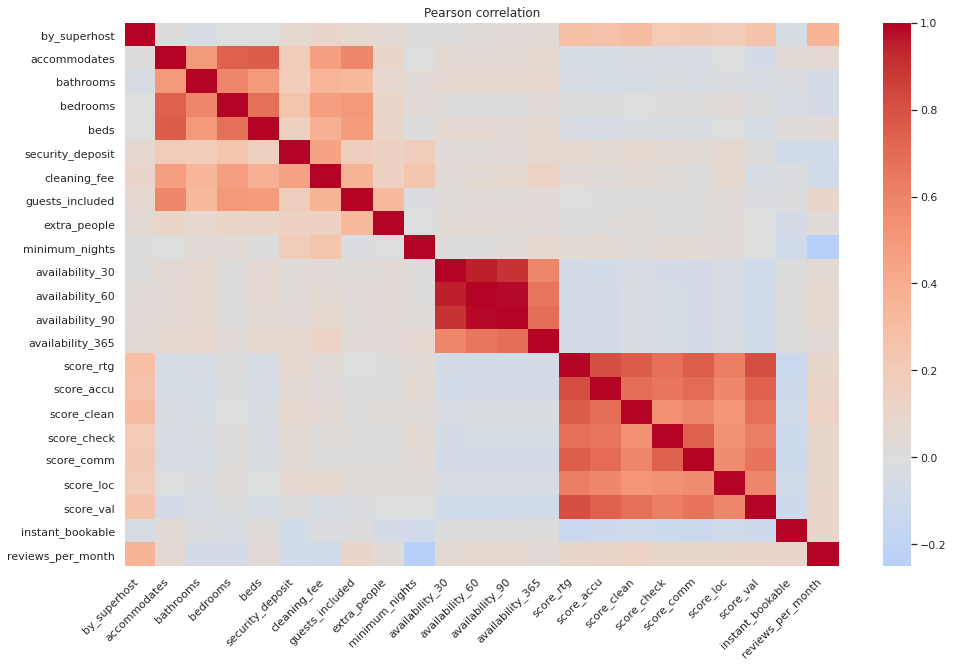

,by_superhost,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_30,availability_60,availability_90,availability_365,score_rtg,score_accu,score_clean,score_check,score_comm,score_loc,score_val,instant_bookable,reviews_per_month
by_superhost,1.000000,0.008601,-0.033902,0.000243,-0.004275,0.069120,0.099536,0.069647,0.049782,0.014695,0.011377,0.029179,0.041956,0.056619,0.289355,0.268245,0.305043,0.205936,0.216805,0.188895,0.264871,-0.053029,0.350983
accommodates,0.008601,1.000000,0.498492,0.741033,0.762833,0.190592,0.472409,0.577245,0.105405,-0.003786,0.051856,0.054159,0.047554,0.068250,-0.047701,-0.047763,-0.026905,-0.036668,-0.035484,-0.002613,-0.067844,0.047168,0.061464
bathrooms,-0.033902,0.498492,1.000000,0.588781,0.492610,0.185544,0.348401,0.315764,0.079357,0.037865,0.064073,0.064674,0.062099,0.081907,-0.043195,-0.048703,-0.049846,-0.030592,-0.036192,-0.020571,-0.045404,-0.020693,-0.068468
bedrooms,0.000243,0.741033,0.588781,1.000000,0.680505,0.242719,0.469083,0.506339,0.103023,0.034130,0.017303,0.016284,0.010838,0.032716,0.007047,-0.007615,0.001189,0.014470,0.010786,0.028017,-0.009571,-0.033209,-0.059680
beds,-0.004275,0.762833,0.492610,0.680505,1.000000,0.153092,0.374736,0.489463,0.103813,0.003404,0.058168,0.058832,0.052824,0.067609,-0.037666,-0.043183,-0.025378,-0.022883,-0.025883,-0.003671,-0.048975,0.020995,0.033759
security_deposit,0.069120,0.190592,0.185544,0.242719,0.153092,1.000000,0.444699,0.173030,0.140937,0.178561,0.025692,0.031960,0.034967,0.063195,0.062928,0.055066,0.069066,0.048894,0.043848,0.062735,0.010492,-0.083978,-0.080963
cleaning_fee,0.099536,0.472409,0.348401,0.469083,0.374736,0.444699,1.000000,0.355291,0.142424,0.249981,0.041148,0.056844,0.063773,0.132119,0.038443,0.026033,0.053993,0.022433,0.008635,0.066388,-0.042635,-0.017259,-0.087321
guests_included,0.069647,0.577245,0.315764,0.506339,0.489463,0.173030,0.355291,1.000000,0.317544,-0.018900,0.021616,0.026288,0.022959,0.038805,0.002255,0.005507,0.014681,0.017049,0.017581,0.025043,-0.019806,-0.006948,0.103439
extra_people,0.049782,0.105405,0.079357,0.103023,0.103813,0.140937,0.142424,0.317544,1.000000,-0.005624,0.045963,0.047072,0.045813,0.038674,0.017450,0.012854,0.031784,0.004550,0.015066,0.032456,0.001712,-0.066550,0.023899
minimum_nights,0.014695,-0.003786,0.037865,0.034130,0.003404,0.178561,0.249981,-0.018900,-0.005624,1.000000,0.012781,0.017027,0.020763,0.066461,0.046514,0.049288,0.019568,0.054736,0.043395,0.023866,0.003168,-0.087312,-0.250867


In [10]:
# Exclude the price and categorical features
exclude = list765.dtypes[list765.dtypes == 'object'].index.tolist() + ['price']
var_list = [col for col in list765.columns if col not in exclude]

# Check for correlation among the features
plt.figure(figsize=(16, 10))
plotting.corr_heatmap(df=list765, var_list=var_list, palette='coolwarm', center=0)

In [11]:
# Drop correlated features, but keep 1 feature from each correlation group
corr_feats = ['bathrooms', 'bedrooms', 'beds', # Keep `accommodates`
              'availability_30', 'availability_60', 'availability_90', # Keep `availability_365`
              'score_accu', 'score_clean', 'score_check', 'score_comm', 'score_loc', 'score_val'] # Keep `score_rtg`
list765.drop(corr_feats, axis=1, inplace=True)
list765.shape

(35563, 16)

In [12]:
# Check for any other high correlations
utils.corr_feats(list765.drop(exclude, axis=1))

[['accommodates', 'guests_included', 0.5772448351406724]]

In [13]:
list765.drop('guests_included', axis=1, inplace=True)
list765.shape

(35563, 15)

***
##### The correlation heatmap shows 3 blocks of high correlation:
1. Room features - `accommodates`, `bathrooms`, `bedrooms`, and `beds`
2. Availability features - `availability_30`, `availability_60`, `availability_90`, and `availability_365`
3. Rating features - `score_rtg`, `score_accu`, `score_clean`, `score_check`, `score_comm`, `score_loc`, and `score_val`

##### In each of these groups, the features have a strong linear relationship, so they are adding complexity without providing much additional information. Therefore, it makes sense to keep only 1 feature from each group and drop the rest. I kept the most general feature in each group. In other words, I intuitively chose features that capture the essence of the entire group:
1. `accommodates` - number of guests the property can accommodate
2. `availability_365` - number of days the property was available in the last 365 days
3. `score_rtg` - overall rating of the listing

##### Aside from the obvious correlation groups, `accommodates` also had a high correlation with `guests_included`, so I dropped `guests_included` because `accommodates` is a more concrete measure of the property's size. This leaves 14 features remaining (not including `price` which will be the target variable), 4 of which are categorical and 10 numerical.

##### Now we will be looking at categorical features. Since most machine learning models don't work with categorical variables, they need to be encoded in a way that is acceptable for models.
1. `neighborhood` - very high cardinality with low frequency on all labels
2. `property_type` - high cardinality, most of which fall into 2 labels
3. `room_type` - 4 unique labels, 2 of which are rare
4. `cancellation_policy` - 7 unique labels, 4 of which are rare

##### Since the last 3 variables on the list can be reduced to 3 labels each, they can be converted into numerical features using one-hot encoding. For each variable, we create 2 additional binary features to represent each unique label (1 label is omitted to reduce complexity). If the value of both binary features are 0, then it stands to reason that the row falls into the 3rd label (the omitted label).
***

### Categorical one-hot encoding

In [14]:
# Rename variables
list765.rename({'property_type': 'prop', 'room_type': 'room', 'cancellation_policy': 'cancel'}, axis=1, inplace=True)

# Rename labels
list765.prop.replace(['Apartment', 'House'], ['apartment', 'house'], inplace=True)
list765.room.replace(['Entire home/apt', 'Private room'], ['entire', 'private'], inplace=True)

list765.head()

,by_superhost,neighborhood,prop,room,accommodates,price,security_deposit,cleaning_fee,extra_people,minimum_nights,availability_365,score_rtg,instant_bookable,cancel,reviews_per_month
0,0,Culver City,Condominium,entire,6,122.0,500.0,240.0,25.0,30,38,80.0,0,strict_14_with_grace_period,0.02
1,0,Burbank,house,entire,6,168.0,0.0,100.0,0.0,15,97,97.0,1,flexible,0.17
2,1,Hollywood,apartment,private,1,79.0,450.0,84.0,0.0,30,281,97.0,1,strict_14_with_grace_period,0.33
3,0,Santa Monica,apartment,private,1,155.0,0.0,100.0,0.0,1,365,94.0,0,strict_14_with_grace_period,0.19
4,0,Bellflower,apartment,entire,2,80.0,100.0,75.0,25.0,15,0,NaN,1,strict_14_with_grace_period,0.00


In [15]:
# Check `cancel` labels
list765.cancel.value_counts()

strict_14_with_grace_period    14933
flexible                       11136
moderate                        9449
strict                            18
super_strict_60                   14
super_strict_30                   11
luxury_moderate                    2
Name: cancel, dtype: int64

In [16]:
# Group labels into "flexible", "moderate", and "strict"
list765['cancel'] = list765.cancel.str.replace('_14_with_grace_period|super_|_60|_30|luxury_', '')
list765.cancel.value_counts()

strict      14976
flexible    11136
moderate     9451
Name: cancel, dtype: int64

In [17]:
# First 2 labels of `prop` and `room`
print(list765.prop.value_counts()[:2])
print()
print(list765.room.value_counts()[:2])

apartment    12434
house        12123
Name: prop, dtype: int64

entire     21958
private    12166
Name: room, dtype: int64


In [18]:
# One-hot encode `prop`, `room`, and `cancel`
df = utils.onehot_encoder(list765, ['prop', 'room', 'cancel'])
df.head()

,by_superhost,neighborhood,accommodates,price,security_deposit,cleaning_fee,extra_people,minimum_nights,availability_365,score_rtg,instant_bookable,reviews_per_month,prop_apartment,prop_house,room_entire,room_private,cancel_strict,cancel_flexible
0,0,Culver City,6,122.0,500.0,240.0,25.0,30,38,80.0,0,0.02,0,0,1,0,1,0
1,0,Burbank,6,168.0,0.0,100.0,0.0,15,97,97.0,1,0.17,0,1,1,0,0,1
2,1,Hollywood,1,79.0,450.0,84.0,0.0,30,281,97.0,1,0.33,1,0,0,1,1,0
3,0,Santa Monica,1,155.0,0.0,100.0,0.0,1,365,94.0,0,0.19,1,0,0,1,1,0
4,0,Bellflower,2,80.0,100.0,75.0,25.0,15,0,NaN,1,0.00,1,0,1,0,1,0


In [19]:
# Confirm the counts are the same
df.iloc[:, -6:].sum()

prop_apartment     12434
prop_house         12123
room_entire        21958
room_private       12166
cancel_strict      14976
cancel_flexible    11136
dtype: int64

***
##### The 3 categorical variables have been encoded as follows:
- `property_type` - created "apartment" and "house" each a binary feature (a 0 in both columns indicates that it was a property other than "house" or "apartment")
- `room_type` - created "Entire house/apt" and "Shared room" each a binary feature (a 0 in both columns indicates that it was either a "Shared room" or "Hotel room")
- `cancellation_policy` - created "strict" and "flexible" each a binary feature (a 0 in both bothoms indicates that it was "moderate")

##### `neighborhood` will be more complicated because of the high cardinality and low frequency of all the labels. Since different areas have different `price` ranges, `neighborhood` can be encoded with some ordinality (based on the average listing `price`). But because all labels have low frequency, they will need to be grouped into bins first.
***

### Encode neighborhood

In [20]:
# Neighborhood listing counts
nb_count = pd.DataFrame(df.neighborhood.value_counts()).reset_index()
nb_count.columns = ['Neighborhood', 'Num_listings']
nb_count.head()

,Neighborhood,Num_listings
0,Hollywood,1843
1,Venice,1800
2,Long Beach,1713
3,Santa Monica,1233
4,Downtown,1187


In [21]:
# Average price of each neighborhood
nb_prices = utils.agg_to_2cols(df=df, agg_col='price', agg_col_name='Price')
nb_prices = pd.merge(nb_prices, nb_count, on='Neighborhood', how='left')
nb_prices.head()

,Neighborhood,Price,Num_listings
0,Malibu,368.94,210
1,Avalon,353.83,41
2,Bel-Air,314.91,34
3,Lake Hughes,300.00,1
4,Beverly Crest,291.07,81


In [22]:
# Group neighborhoods into listing price tiers into balanced bins
print('Neighborhoods with an average listing price:')
print('- Less than or equal to 100:', nb_prices[nb_prices.Price <= 100].Num_listings.sum())
print('- Between 100 and 120:', nb_prices[(nb_prices.Price > 100) & (nb_prices.Price <= 120)].Num_listings.sum())
print('- Between 120 and 140:', nb_prices[(nb_prices.Price > 120) & (nb_prices.Price <= 140)].Num_listings.sum())
print('- Between 140 and 150:', nb_prices[(nb_prices.Price > 140) & (nb_prices.Price <= 150)].Num_listings.sum())
print('- Between 150 and 180:', nb_prices[(nb_prices.Price > 150) & (nb_prices.Price <= 180)].Num_listings.sum())
print('- Greater than 180:', nb_prices[nb_prices.Price > 180].Num_listings.sum())

Neighborhoods with an average listing price:
- Less than or equal to 100: 6049
- Between 100 and 120: 6376
- Between 120 and 140: 5405
- Between 140 and 150: 5598
- Between 150 and 180: 6055
- Greater than 180: 6080


In [23]:
# List of neighborhoods in each price tier
nb_tiers = []
nb_tiers.append(nb_prices[nb_prices.Price <= 100].Neighborhood.tolist())
nb_tiers.append(nb_prices[(nb_prices.Price > 100) & (nb_prices.Price <= 120)].Neighborhood.tolist())
nb_tiers.append(nb_prices[(nb_prices.Price > 120) & (nb_prices.Price <= 140)].Neighborhood.tolist())
nb_tiers.append(nb_prices[(nb_prices.Price > 140) & (nb_prices.Price <= 150)].Neighborhood.tolist())
nb_tiers.append(nb_prices[(nb_prices.Price > 150) & (nb_prices.Price <= 180)].Neighborhood.tolist())
nb_tiers.append(nb_prices[nb_prices.Price > 180].Neighborhood.tolist())

[len(nb) for nb in nb_tiers]

[103, 52, 33, 19, 25, 31]

In [24]:
# Create a `price_tier` feature
df['price_tier'] = 1
for i in range(1, 6):
    df['price_tier'] = df.apply(lambda r: utils.check_nb(row=r, tier=i+1, nb_list=nb_tiers[i]), axis=1)
df.price_tier.value_counts().sort_index()

1    6049
2    6376
3    5405
4    5598
5    6055
6    6080
Name: price_tier, dtype: int64

In [25]:
# Drop `neighborhood` and `score_rtg`
df.drop(['neighborhood', 'score_rtg'], axis=1, inplace=True)
df.head()

,by_superhost,accommodates,price,security_deposit,cleaning_fee,extra_people,minimum_nights,availability_365,instant_bookable,reviews_per_month,prop_apartment,prop_house,room_entire,room_private,cancel_strict,cancel_flexible,price_tier
0,0,6,122.0,500.0,240.0,25.0,30,38,0,0.02,0,0,1,0,1,0,4
1,0,6,168.0,0.0,100.0,0.0,15,97,1,0.17,0,1,1,0,0,1,2
2,1,1,79.0,450.0,84.0,0.0,30,281,1,0.33,1,0,0,1,1,0,4
3,0,1,155.0,0.0,100.0,0.0,1,365,0,0.19,1,0,0,1,1,0,5
4,0,2,80.0,100.0,75.0,25.0,15,0,1,0.00,1,0,1,0,1,0,1


***
##### I dropped `neighborhood` because it has already been encoded in `price_tier`. I dropped `score_rtg` because more than 20% of its values are missing and almost 90% of the existing values are between 90 and 100, so it may not be useful feature. That leaves 16 features remaining.

##### With all the categorical variables encoded and missing values dealt with, we are ready to start modeling. We will first log transform the target to normalize its distribution.
***

### Train-test split

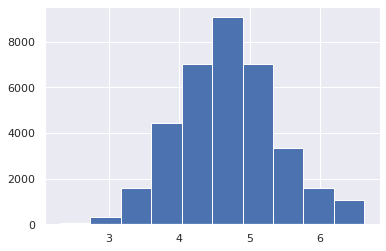

In [26]:
# Split data into features and log-transformed target
X = df.drop('price', axis=1).copy()
y = utils.log_transform(df['price'])
y.hist()

In [27]:
# 60-20-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
X_test = X_test.copy()

print('Train set:', X_train.shape, y_train.shape)
print('Validation set:', X_val.shape, y_val.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (21337, 16) (21337,)
Validation set: (7113, 16) (7113,)
Test set: (7113, 16) (7113,)


### Encode price tier in a more meaningful way

In [28]:
# Combine X_train and y_train
train = X_train.copy()
train['price'] = y_train.copy()

# Calculate the average `price` of each tier
tier_prices = train.groupby('price_tier').price.mean().round(2).to_dict()

# Encode `price_tier` using the average `price` of each tier
X_train['price_tier'] = X_train.price_tier.map(tier_prices)
X_train.price_tier.value_counts().sort_index()

4.19    3658
4.48    3881
4.64    3212
4.79    3293
4.91    3653
5.16    3640
Name: price_tier, dtype: int64

In [29]:
# Do the same for the validation and test sets using the same mapping
X_val['price_tier'] = X_val.price_tier.map(tier_prices)
X_test['price_tier'] = X_test.price_tier.map(tier_prices)
X_val.price_tier.value_counts().sort_index(), X_test.price_tier.value_counts().sort_index()

(4.19    1187
 4.48    1233
 4.64    1085
 4.79    1157
 4.91    1227
 5.16    1224
 Name: price_tier, dtype: int64,
 4.19    1204
 4.48    1262
 4.64    1108
 4.79    1148
 4.91    1175
 5.16    1216
 Name: price_tier, dtype: int64)

***
##### The values of `price_tier` now provides more information than just an ordering. I decided to perform the second encoding (using the mean target of each label) after the data split in order to minimize the data leakage. After all, the validation and test sets are supposed to simulate unseen data, so this data shouldn't leak over to the training set. I had created the `price_tier` feature from the entire dataset (before the split) by encoding `neighborhood` with numeric labels because that process was lot more complicated. Since the first encoding was based on intervals, the leak isn't as severe because observations would likely fall within the same or adjacent interval even if the encoding was done after the split.
*** 

### Correlation

In [30]:
# Check for correlated features
print(utils.corr_feats(X_train))

[['prop_apartment', 'prop_house', 0.5263927945153837], ['room_entire', 'room_private', 0.9152014469134085], ['cancel_strict', 'cancel_flexible', 0.5718935781750188]]


In [31]:
# Drop `room_private`
X_train.drop('room_private', axis=1, inplace=True)
X_val.drop('room_private', axis=1, inplace=True)
X_test.drop('room_private', axis=1, inplace=True)
X_train.shape

(21337, 15)

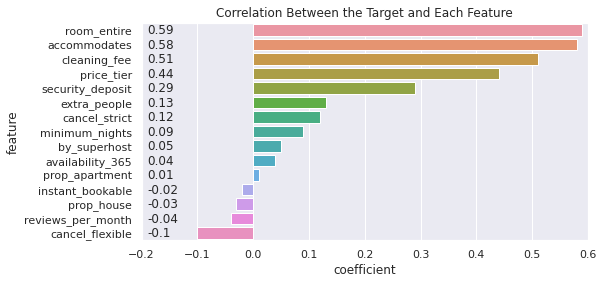

In [32]:
# Check correlation between the target and each feature
corr_with_target = [y_train.corr(X_train[feat]).round(2) for feat in X_train.columns]
target_corr = utils.feat_coefs(feats=X_train.columns, coefs=corr_with_target, feat_name='feature', coef_name='coefficient')

# Horizontal barplot
plt.figure(figsize=(8, 4))
sns.barplot(data=target_corr, y='feature', x='coefficient')
plt.title('Correlation Between the Target and Each Feature')
plt.xlim(-0.2, 0.6)

# Label bars
for i in range(target_corr.shape[0]):
    n = target_corr.iloc[i, 1]
    plt.text(-0.19, i + 0.01, f'{n}', va='center')
            
plt.show()

***
##### All 3 pairs of one-hot encoded features had a correlation coefficient of greater than 0.5. Since each pair came from the same variable originally, it is expected that there would be some correlation between the two in each pair. For this reason, I increased the correlation threshold to 0.7, leaving only `room_entire` and `room_private`, which had a correlation of 0.915. I dropped `room_private`, so now the original `room` feature is interpretted as whether or not the the guest is booking the entire property.

##### From the barplot, it is clear that `room_entire`, `accommodates`, `cleaning_fee`, `price_tier`, and `security_deposit` have the highest correlation with the target variable (log `price`). These 5 features may be the best predictor variables when using linear models to predict the `price`.

##### Currently, several of the features are on a completely different scale. There are binary features (like `by_superhost` and `instant_bookable`) which only contain 0s and 1s, while `security_deposit` vary from 0 to over 5,000. These values need to be normalized before using linear models, so we will be scaling each feature using its mean and standard deviation.
***

### Scale features

In [33]:
# Scale the train set
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_train_scaled.head()

,by_superhost,accommodates,security_deposit,cleaning_fee,extra_people,minimum_nights,availability_365,instant_bookable,reviews_per_month,prop_apartment,prop_house,room_entire,cancel_strict,cancel_flexible,price_tier
0,-0.696000,-0.595332,-0.446898,-0.390535,-0.573712,1.307398,-0.263025,1.143111,-0.034023,-0.731613,1.389860,-1.269751,1.185091,-0.677746,-1.596805
1,-0.696000,0.235936,2.849694,-0.453289,-0.573712,1.307398,1.407738,1.143111,-0.718528,1.366844,-0.719497,0.787556,-0.843817,1.475480,-1.596805
2,-0.696000,-0.595332,-0.446898,-0.578799,-0.573712,-1.290240,-1.154566,-0.874806,-0.559204,-0.731613,-0.719497,-1.269751,-0.843817,-0.677746,-0.164935
3,-0.696000,0.235936,-0.446898,-0.955327,-0.573712,-0.036208,-1.154566,-0.874806,-0.753934,1.366844,-0.719497,0.787556,-0.843817,1.475480,1.489670
4,1.436781,-0.595332,-0.446898,-0.955327,-0.179887,-0.036208,1.246278,-0.874806,-0.216951,-0.731613,-0.719497,-1.269751,-0.843817,-0.677746,-0.674044


In [34]:
# Scale the validation set
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_val_scaled.head(2)

,by_superhost,accommodates,security_deposit,cleaning_fee,extra_people,minimum_nights,availability_365,instant_bookable,reviews_per_month,prop_apartment,prop_house,room_entire,cancel_strict,cancel_flexible,price_tier
0,-0.696,-0.595332,-0.446898,-0.829818,-0.573712,-0.036208,-0.628065,-0.874806,0.432149,1.366844,-0.719497,-1.269751,-0.843817,-0.677746,0.694187
1,-0.696,-0.595332,-0.446898,-0.955327,-0.573712,1.307398,-1.154566,-0.874806,-0.771637,1.366844,-0.719497,-1.269751,-0.843817,1.475480,-0.164935


In [35]:
# Scale the test set
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_test_scaled.head(2)

,by_superhost,accommodates,security_deposit,cleaning_fee,extra_people,minimum_nights,availability_365,instant_bookable,reviews_per_month,prop_apartment,prop_house,room_entire,cancel_strict,cancel_flexible,price_tier
0,-0.696,0.235936,-0.282068,0.237013,0.410850,-1.290240,1.407738,1.143111,0.013185,1.366844,-0.719497,0.787556,1.185091,-0.677746,-1.596805
1,-0.696,0.651570,-0.199654,0.174258,-0.573712,1.307398,-1.154566,1.143111,-0.063527,-0.731613,1.389860,0.787556,1.185091,-0.677746,-0.674044


### Linear regression

In [36]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
print('Train R2 Score:', lr.score(X_train_scaled, y_train))
print('Val R2 Score:', lr.score(X_val_scaled, y_val))

Train R2 Score: 0.6092098773474379
Val R2 Score: 0.6135913216099094


In [38]:
# Predict train and validation sets
pred_val_lr, pred_train_lr = utils.make_pred(model=lr, df_test=X_val_scaled, df_train=X_train_scaled)

# Root mean squared error
rmse_val_lr, rmse_train_lr = utils.score_rmse(true_test=y_val, pred_test=pred_val_lr, true_train=y_train, pred_train=pred_train_lr)
print('Train RMSE:', rmse_train_lr)
print('Val RMSE:', rmse_val_lr)

Train RMSE: 83.54105366301414
Val RMSE: 82.60833881917733


### Lasso regression

In [40]:
for a in [10 ** e for e in range(-10, 3, 2)]:
    lasso = Lasso(alpha=a, max_iter=1e6, random_state=0)
    lasso.fit(X_train_scaled, y_train)
    print(f'alpha={a}')
    print('Train R2 Score:', lasso.score(X_train_scaled, y_train))
    print('Val R2 Score:', lasso.score(X_val_scaled, y_val))
    print()

alpha=1e-10
Train R2 Score: 0.6092098773474379
Val R2 Score: 0.6135913216041096

alpha=1e-08
Train R2 Score: 0.609209877347435
Val R2 Score: 0.6135913210670543

alpha=1e-06
Train R2 Score: 0.6092098773177775
Val R2 Score: 0.6135912639736345

alpha=0.0001
Train R2 Score: 0.6092095823541043
Val R2 Score: 0.613585544178712

alpha=0.01
Train R2 Score: 0.6065719093565767
Val R2 Score: 0.6104653517621763

alpha=1
Train R2 Score: 0.0
Val R2 Score: -6.307023551510582e-05



In [43]:
# Coefficients
utils.feat_coefs(X_train_scaled.columns, lasso.coef_)

,feat,coef
1,accommodates,0.244535
11,room_entire,0.234955
14,price_tier,0.217583
3,cleaning_fee,0.085644
2,security_deposit,0.041524
4,extra_people,0.024224
13,cancel_flexible,0.017764
0,by_superhost,0.016551
10,prop_house,0.015020
6,availability_365,0.003046


### Elastic net regression

In [53]:
# Estimator
en = ElasticNet(max_iter=1e6, random_state=0)

# Parameter grid
grid = {'alpha': [10 ** e for e in range(-6, 3, 2)],
        'l1_ratio': np.arange(0.1, 1, 0.2)}

# Grid search
en_search = GridSearchCV(en, grid, cv=5, n_jobs=5, verbose=1)
en_search.fit(X_train_scaled, y_train)

# Best estimator
print('Best score:', en_search.best_score_)
en_search.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Best score: 0.6084897804017737


[Parallel(n_jobs=5)]: Done 115 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    0.4s finished


{'alpha': 0.0001, 'l1_ratio': 0.1}

### K-neighbors